Normal approximation for the model for bioassay experiment (BDA3 p.86)

In [15]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# load data
df = pd.read_csv('../data/bioassay.csv')
x = df.dose.values
n = df.num_animals.values
y = df.num_deaths.values

### Posterior density

In [17]:
# Compute the posterior density in grid
ngrid = 100
a_grid = np.linspace(-5, 10, ngrid)
b_grid = np.linspace(-10, 40, ngrid)
inv_logit_x = 1 / (np.exp(-(a_grid[:,np.newaxis] + np.outer(b_grid, x)[:, np.newaxis, :])) + 1)
likelihood = np.prod(inv_logit_x**y * (1 - inv_logit_x)**(n - y), axis=2)  # 100 by 100 
# Since the prior is uniform, the posterior is proportional to the likelihood
post_den = likelihood / np.sum(likelihood)

# draws from unnormalized posterior density
# seed a random state
rng = np.random.RandomState(123)

n_sample = 1000
sample_ind = np.unravel_index(rng.choice(post_den.size, size=n_sample, p=post_den.ravel()), post_den.shape)
sample_a = a_grid[sample_ind[1]]
sample_b = b_grid[sample_ind[0]]
# add random jitter
sample_a += (rng.rand(n_sample) - 0.5) * (a_grid[1]-a_grid[0])
sample_b += (rng.rand(n_sample) - 0.5) * (b_grid[1]-b_grid[0])

# samples of LD50 conditional on beta > 0
b_pos_ind = sample_b > 0
sample_ld50 = -sample_a[b_pos_ind]/sample_b[b_pos_ind]

### Maximize log posterior: find the mode and inverse Hessian

In [18]:
# Define the objective function (negative log posterior)
def neg_log_post(w):
    z = np.exp(w[0] + w[1] * x)
    sigmod = z / (1 + z)
    log_p = - np.sum(y * np.log(sigmod) + (n - y) * np.log(1 - sigmod))
    return log_p

w0 = np.array([0, 0]) # initial values
optim = minimize(neg_log_post, w0, method = 'BFGS')
# extract mode and (approximated) inverse Hessian 
w, inv_H = optim['x'], optim['hess_inv']

### Compute the density from normal approximation

In [19]:
# Construct a grid array of shape (ngrid, ngrid, 2) from a_grid and b_grid.
aa, bb = np.meshgrid(a_grid, b_grid)
grid = np.dstack((aa, bb))

p_norm = multivariate_normal.pdf(x=grid, mean=w, cov=inv_H)

# Draw samples from the normal approximation distribution
sample_norm = multivariate_normal.rvs(mean=w, cov=inv_H, size=n_sample)

# samples of LD50 conditional on beta > 0 for normal approx.
b_pos_ind_norm = sample_norm[:,1] > 0
sample_ld50_norm = -sample_norm[b_pos_ind_norm,0]/sample_norm[b_pos_ind_norm,1]

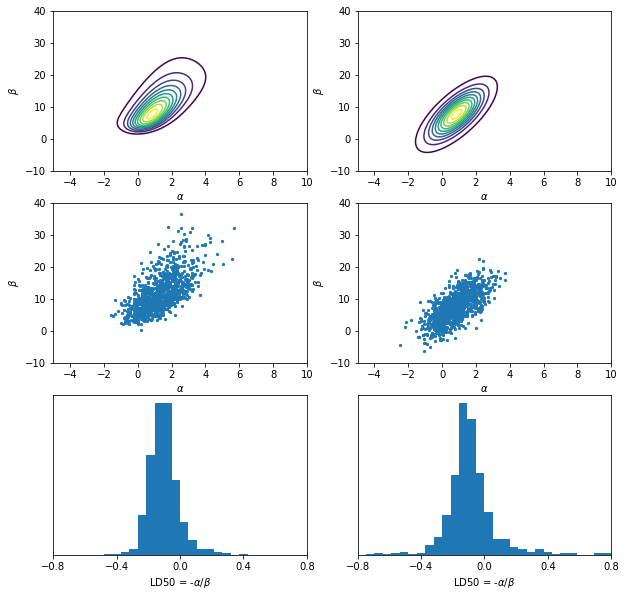

In [26]:
# plot
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# plot the posterior density
ax = axes[0, 0]
ax.contour(a_grid, b_grid, post_den, levels = np.arange(0.05, 1, 0.1)*post_den.max())
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$');

# plot the samples from posterior density
ax = axes[1, 0]
ax.scatter(sample_a, sample_b, 5)
ax.set_xlim([-5, 10])
ax.set_ylim([-10, 40])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$');

# plot the histogram of LD50
ax = axes[2, 0]
ax.hist(sample_ld50, np.linspace(-0.8, 0.8, 31))
ax.set_xlim([-0.8, 0.8])
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.8, 0.8, 5));

# plot the posterior density for normal approx.
ax = axes[0, 1]
ax.contour(a_grid, b_grid, p_norm, levels = np.arange(0.05, 1, 0.1)*p_norm.max())
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$');

# plot the samples from the normal approx.
ax = axes[1, 1]
ax.scatter(sample_norm[:,0], sample_norm[:,1], 5)
ax.set_xlim([-5, 10])
ax.set_ylim([-10, 40])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$');

# Plot the histogram of LD50 from the normal approx.
ax = axes[2, 1]
ax.hist(sample_ld50_norm, np.linspace(-0.8, 0.8, 31))
ax.set_xlim([-0.8, 0.8])
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.8, 0.8, 5));